### Solve IK for `Common Rig H EmotionMocap` 

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2r,r2quat,get_uv_dict_em,get_p_target_em, rpy2R
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.6]


### Parse `scene_common_rig_h.xml`

In [2]:
xml_path = '../asset/common_rig/scene_common_rig.xml'
env = MuJoCoParserClass(name='myosuite',rel_xml_path=xml_path,VERBOSE=True)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    body_idx = env.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs:
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]
print ("Done.")

dt:[0.0050] HZ:[200]
n_dof (=nv):[41]
n_geom:[26]
geom_names:['floor', 'base', 'root2spine', 'spine2neck', 'neck2rshoulder', 'neck2lshoulder', 'rshoulder2relbow', 'relbow2rwrist', 'rthumb', 'rpalm', 'lshoulder2lelbow', 'lelbow2lwrist', 'lthumb', 'lpalm', 'head', 'nose', 'base2rpelvis', 'rpelvis2rknee', 'rknee2rankle', 'rankle', 'rfoot', 'base2lpelvis', 'lpelvis2lknee', 'lknee2lankle', 'lankle', 'lfoot']
n_body:[20]
body_names:['world', 'base', 'torso', 'spine', 'neck', 'right_shoulder', 'right_elbow', 'right_hand', 'left_shoulder', 'left_elbow', 'left_hand', 'head', 'right_leg', 'right_pelvis', 'right_knee', 'right_ankle', 'left_leg', 'left_pelvis', 'left_knee', 'left_ankle']
n_joint:[36]
joint_names:['base', 'root1', 'root2', 'root3', 'spine', 'rs1', 'rs2', 'rs3', 're', 'rw1', 'rw2', 'rw3', 'ls1', 'ls2', 'ls3', 'le', 'lw1', 'lw2', 'lw3', 'head1', 'head2', 'head3', 'rp1', 'rp2', 'rp3', 'rk', 'ra1', 'ra2', 'ra3', 'lp1', 'lp2', 'lp3', 'lk', 'la1', 'la2', 'la3']
joint_types:[0 3 3 3 3 3 3

In [ ]:
from bvh.skeleton import process_bvhfile, process_bvhkeyframe
from collections import deque

mocap = process_bvhfile("../asset/bvh/F01A0V1.bvh", DEBUG=False)

node = mocap.root
deq = deque()
while len(node.children) > 0:
    if len(deq) > 0:
        node = deq.pop()
        print(node.name)

    for child in node.children:
        deq.append(child)

Reading BVH file...
done
Building skeleton...
done
Spine at strans=[ 0.   14.35  0.  ] is connected to Spine1 
Spine1 at strans=[0.   9.75 0.  ] is connected to Spine2 
Spine2 at strans=[ 0.   10.15  0.  ] is connected to Spine3 
Spine3 at strans=[0.   9.75 0.  ] is connected to Neck RightShoulder LeftShoulder 
Neck at strans=[ 0.   10.42  0.  ] is connected to Head 
Head at strans=[0. 9. 0.] is connected to HeadEnd 
HeadEnd at strans=[ 0. 16.  0.] is connected to nothing
RightShoulder at strans=[-3.2   6.95  0.  ] is connected to RightArm 
RightArm at strans=[-12.8   0.    0. ] is connected to RightForeArm 
RightForeArm at strans=[-27.   0.   0.] is connected to RightHand 
RightHand at strans=[-26.   0.   0.] is connected to RightHandThumb1 RightInHandIndex RightInHandMiddle RightInHandRing RightInHandPinky 
RightHandThumb1 at strans=[-2.56  0.2   3.21] is connected to RightHandThumb2 
RightHandThumb2 at strans=[-3.79  0.    0.  ] is connected to RightHandThumb3 
RightHandThumb3 at st

### Target BVH

In [4]:
# code edited from https://github.com/tekulvw/bvh-converter

from bvh.skeleton import process_bvhfile, process_bvhkeyframe

mocap = process_bvhfile("../asset/bvh/F01A0V1.bvh", DEBUG=False)
# index = [0,                     # Hips
#         9,10,11,12,             # Spine
#         44,45,46,47,            # LeftShoulder ~ LeftHand
#         16,17,18,19,            # RightShoulder ~ RightHand
#         5,6,7,8,1,2,3,4]        # LeftUpLeg ~ LeftFoot, RightUpLeg ~ RightFoot
index = [0,9,10,11,12,44,45,46,47,          # Hips, Spine, LeftShoulder ~ LeftHand
        67,68,69,70,71,62,63,64,65,66,      # LeftPinky, LeftRing
        57,58,59,60,61,52,53,54,55,56,      # LeftMiddle, LeftIndex
        48,49,50,51,16,17,18,19,            # LeftThumb, RightShoulder ~ RightHand
        39,40,41,42,43,34,35,36,37,38,      # RightPinky, RightRing
        29,30,31,32,33,24,25,26,27,28,      # RightMiddle, RightIndex
        20,21,22,23,13,14,15,               # RightThumb, Neck, Head
        5,6,7,8,1,2,3,4]                    # LeftUpLeg ~ LeftFoot, RightUpLeg ~ RightFoot

print("Analyzing frames...")
for i in range(mocap.frames):
    new_frame = process_bvhkeyframe(mocap.keyframes[i], mocap.root, mocap.dt * i)
print("done")

pos_header, pos = mocap.get_frames_worldpos()
rot_header, rot = mocap.get_frames_rotations()

num_frames = mocap.frames
num_joints = 72

p_full = np.zeros((num_frames, num_joints, 3))
r_full = np.zeros((num_frames, num_joints, 3))
timesteps = np.zeros(num_frames)

for i in range(num_frames):
    timesteps[i] = i * mocap.dt
    for (j,k) in enumerate(index):
        p_full[i,k,:] = np.array(pos[i][3*j+1:3*j+4]) / 100 # cm to mm
        r_full[i,k,:] = np.array(rot[i][3*j+1:3*j+4])

p_full = p_full[:,:,[2,0,1]]
r_full = r_full[:,:,[2,0,1]]

frame_number = 0
p = p_full[frame_number]
r = r_full[frame_number]

uv_dict = get_uv_dict_em(p)
p_target = get_p_target_em(p, uv_dict)

Reading BVH file...


done
Building skeleton...
done
Analyzing frames...
done


In [5]:
node = mocap.root
from collections import deque
deq = deque()
while len(node.children) > 0:
    # print(node.children)
    if len(deq) > 0:
        node = deq.pop()
        world_pos_node = np.array(list(node.worldpos.values()))[:, :3]
    else:
        for child in node.children:
            deq.append(child)
    # print(len(deque))

### Set IK targets (`24` in total: `10` for body & `14` for hands)

In [6]:
# Initialize MuJoCo viewer
env.init_viewer(viewer_title='Common Rig H EmotionMocap',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=152,distance=3.0,elevation=-30,lookat=[0.02,-0.03,0.8])
env.reset()

# Set which joints to control
ctrl_joint_names = env.ctrl_names # <==
joint_idxs_fwd = env.get_idxs_fwd(joint_names=ctrl_joint_names)
joint_idxs_jac = env.get_idxs_jac(joint_names=ctrl_joint_names)
q_ctrl_init = env.get_qpos_joints(ctrl_joint_names)
n_ctrl_joint = len(ctrl_joint_names)

env.body_names
# ik_body_names = ['right_pelvis','right_knee','right_ankle','left_pelvis','left_knee','left_ankle','spine','neck',
#                  'right_shoulder','right_elbow','right_wrist','left_shoulder','left_elbow','left_wrist',
#                  'rh_meta_1','rh_prox_1','rh_dist_1','rh_tip_1',
#                  'rh_meta_2','rh_prox_2','rh_med_2','rh_dist_2','rh_tip_2',
#                  'rh_meta_3','rh_prox_3','rh_med_3','rh_dist_3','rh_tip_3',
#                  'rh_meta_4','rh_prox_4','rh_med_4','rh_dist_4','rh_tip_4',
#                  'rh_meta_5','rh_prox_5','rh_med_5','rh_dist_5','rh_tip_5',
#                  'lh_meta_1','lh_prox_1','lh_dist_1','lh_tip_1',
#                  'lh_meta_2','lh_prox_2','lh_med_2','lh_dist_2','lh_tip_2',
#                  'lh_meta_3','lh_prox_3','lh_med_3','lh_dist_3','lh_tip_3',
#                  'lh_meta_4','lh_prox_4','lh_med_4','lh_dist_4','lh_tip_4',
#                  'lh_meta_5','lh_prox_5','lh_med_5','lh_dist_5','lh_tip_5']
ik_body_names = ['right_pelvis','right_knee','right_ankle','left_pelvis','left_knee','left_ankle','spine','neck',
                 'right_shoulder','right_elbow','right_hand','left_shoulder','left_elbow','left_hand']

ik_target_indices = [1,2,3,5,6,7,11,13,
                     17,18,19,45,46,47]

IK_Ps = [True]*len(ik_body_names)
IK_Rs = [False]*len(ik_body_names)

ik_p_trgts = []
ik_R_trgts = []

for body in ik_body_names:
    ik_p_trgts.append(p_target[body])

for i in ik_target_indices:
    ik_R_trgts.append(rpy2R(np.radians(r[i]),[1,2,0]))

### Loop

2023-11-13 01:34:04.892 python[88369:5363115] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


Pressed ESC
Quitting.


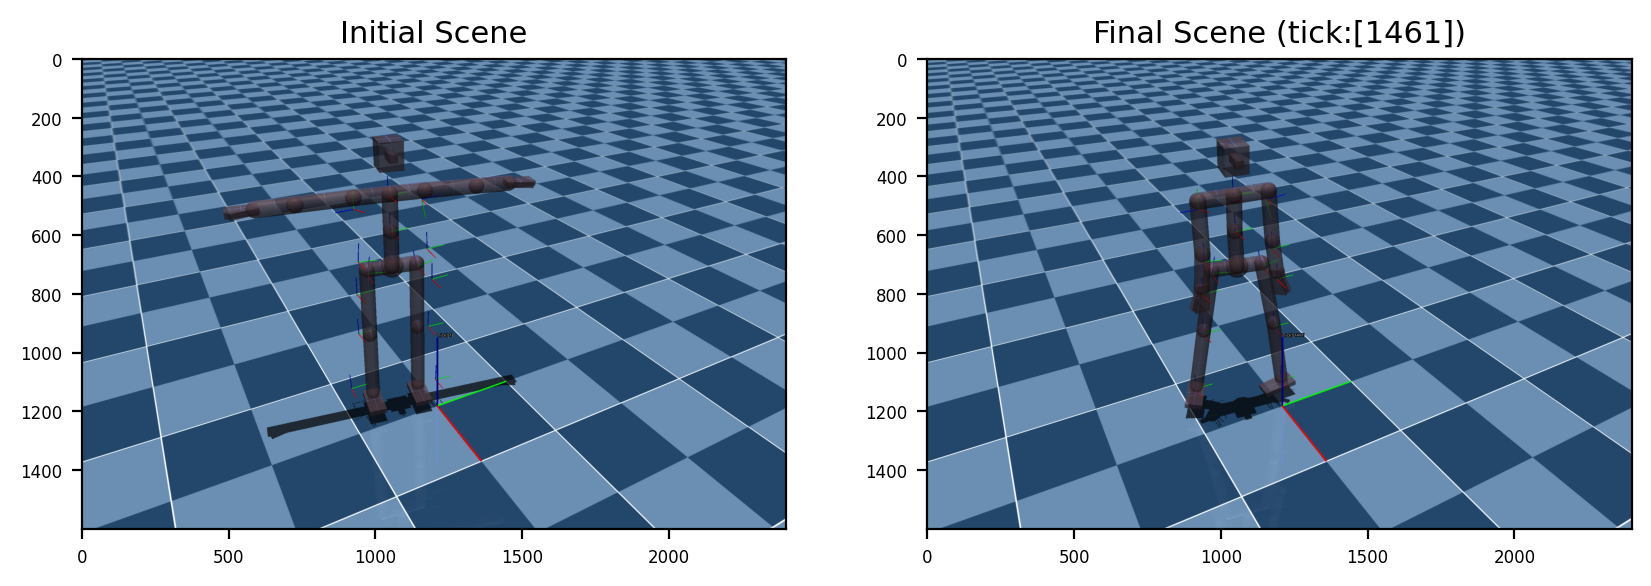

In [7]:
# Reset and loop 
q = q_ctrl_init.copy()

# # Good starting position
# init_joint_names = ['rs1','rs2','rs3','ls1','ls2','ls3','re','le']
# q_init = np.radians([70,25,-5,-70,-25,-5,35,-35])
# joint_idxs_init = [env.model.joint(jname).qposadr[0] for jname in init_joint_names]
# env.forward(q=q_init,joint_idxs=joint_idxs_init)

PERTURB_BASE_POSITION = True
if PERTURB_BASE_POSITION:
    jntadr = env.model.body('base').jntadr[0]
    qposadr = env.model.jnt_qposadr[jntadr]
    base_pos = p[0] # modify base position
    env.data.qpos[qposadr:qposadr+3] = base_pos
    env.data.qpos[qposadr+3:qposadr+7] = r2quat(rpy2R(np.radians(r[0]),[1,2,0]))

FIRST_FLAG = True
while env.is_viewer_alive():
    
    # Solve inverse kinematics
    J_list,ik_err_list = [],[]
    for ik_idx,ik_body_name in enumerate(ik_body_names):
        ik_p_trgt = ik_p_trgts[ik_idx]
        ik_R_trgt = ik_R_trgts[ik_idx]
        IK_P = IK_Ps[ik_idx]
        IK_R = IK_Rs[ik_idx]
        J,ik_err = env.get_ik_ingredients(
            body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
            IK_P=IK_P,IK_R=IK_R)
        J_list.append(J)
        ik_err_list.append(ik_err)
    J_stack      = np.vstack(J_list)
    ik_err_stack = np.hstack(ik_err_list)
    dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
    q = q + dq[joint_idxs_jac]
    
    # FK
    env.data.qpos[joint_idxs_fwd] = q
    q_couple = env.data.qpos.copy()

    env.forward(q=q_couple,INCREASE_TICK=True)
    
    if env.loop_every(tick_every=10):
        # Plot world frame
        env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                   PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
        
        # Text information
        env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3),PLOT_AXIS=False,
                   label='Tick:[%d]'%(env.tick))
        
        # Plot bodies
        env.plot_body_T(body_name='base',PLOT_AXIS=False,axis_len=0.5,axis_width=0.01)
        for body_name in env.body_names:
            p,R = env.get_pR_body(body_name=body_name)
            env.plot_T(p=p,R=R,PLOT_AXIS=False,axis_len=0.05,axis_width=0.005)
            
        # Plot IK target
        for ik_idx,ik_body_name in enumerate(ik_body_names):
            ik_p_trgt = ik_p_trgts[ik_idx]
            ik_R_trgt = ik_R_trgts[ik_idx]
            # env.plot_body_T(body_name=ik_body_name,
                            # PLOT_AXIS=True,axis_len=0.2,axis_width=0.01)
            env.plot_T(p=ik_p_trgt,R=ik_R_trgt,
                       PLOT_AXIS=True,axis_len=0.1,axis_width=0.002)
        
        # Plot revolute joints with arrow
        # for rev_joint_idx,rev_joint_name in zip(env.rev_joint_idxs,env.rev_joint_names):
        #     axis_joint = env.model.jnt_axis[rev_joint_idx]
        #     p_joint,R_joint = env.get_pR_joint(joint_name=rev_joint_name)
        #     axis_world = R_joint@axis_joint
        #     axis_rgba = np.append(np.eye(3)[:,np.argmax(axis_joint)],0.2)
        #     axis_len,axis_r = 0.1,0.01
        #     env.plot_arrow_fr2to(
        #         p_fr=p_joint,p_to=p_joint+axis_len*axis_world,
        #         r=axis_r,rgba=axis_rgba)
            
        # Plot contact information
        # env.plot_contact_info(h_arrow=0.01,rgba_arrow=[1,0,0,0.01],r_sphere=0.005,
        #                       PRINT_CONTACT_BODY=True)
        env.render()

    # Save image
    if env.is_viewer_alive() and FIRST_FLAG:
        scene_img_init = env.grab_image()
    if env.is_viewer_alive() and env.loop_every(tick_every=100):
        scene_img_final = env.grab_image()
    FIRST_FLAG = False
        
# Close MuJoCo viewer
env.close_viewer()

# Plot initial and final scenes
fig,axs = plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(top=0.85,bottom=0.15,wspace=0.2,hspace=0.5)
axs[0].imshow(scene_img_init)
axs[0].set_title('Initial Scene',fontsize=11)
axs[1].imshow(scene_img_final)
axs[1].set_title('Final Scene (tick:[%d])'%(env.tick),fontsize=11)
plt.show()

### Entire Sequence

In [ ]:
import numpy as np
import pickle
from bvh.skeleton import process_bvhfile, process_bvhkeyframe

mocap = process_bvhfile("../asset/bvh/M02F4V1.bvh", DEBUG=False)
index = [0,10,11,12,13,44,45,46,47,         # Hips, Spine, LeftShoulder ~ LeftHand
        67,68,69,70,71,62,63,64,65,66,      # LeftPinky, LeftRing
        57,58,59,60,61,52,53,54,55,56,      # LeftMiddle, LeftIndex
        48,49,50,51,16,17,18,19,            # LeftThumb, RightShoulder ~ RightHand
        39,40,41,42,43,34,35,36,37,38,      # RightPinky, RightRing
        29,30,31,32,33,24,25,26,27,28,      # RightMiddle, RightIndex
        20,21,22,23,13,14,15,               # RightThumb, Neck, Head
        5,6,7,8,1,2,3,4]                    # LeftUpLeg ~ LeftFoot, RightUpLeg ~ RightFoot

print("Analyzing frames...")
for i in range(mocap.frames):
    new_frame = process_bvhkeyframe(mocap.keyframes[i], mocap.root, mocap.dt * i)
print("done")

pos_header, pos = mocap.get_frames_worldpos()
rot_header, rot = mocap.get_frames_rotations()

num_frames = mocap.frames
num_joints = 72

p_full = np.zeros((num_frames, num_joints, 3))
r_full = np.zeros((num_frames, num_joints, 3))
timesteps = np.zeros(num_frames)

for i in range(num_frames):
    timesteps[i] = i * mocap.dt
    for (j,k) in enumerate(index):
        p_full[i,k,:] = np.array(pos[i][3*j+1:3*j+4]) / 100
        r_full[i,k,:] = np.array(rot[i][3*j+1:3*j+4])

p_full = p_full[:,:,[2,0,1]]
r_full = r_full[:,:,[2,0,1]]

qpos_data = np.zeros((num_frames, env.data.qpos.shape[0]))

# Initialize MuJoCo viewer
env.init_viewer(viewer_title='Common Rig H EmotionMocap',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=152,distance=3.0,elevation=-30,lookat=[0.02,-0.03,0.8])

for timestep in range(num_frames):
    p = p_full[timestep]
    r = r_full[timestep]
    uv_dict = get_uv_dict_em(p)
    p_target = get_p_target_em(p, uv_dict)

    env.reset()

    # Set which joints to control
    ctrl_joint_names = env.ctrl_names # <==
    joint_idxs_fwd = env.get_idxs_fwd(joint_names=ctrl_joint_names)
    joint_idxs_jac = env.get_idxs_jac(joint_names=ctrl_joint_names)
    q_ctrl_init = env.get_qpos_joints(ctrl_joint_names)
    n_ctrl_joint = len(ctrl_joint_names)

    ik_body_names = ['right_pelvis','right_knee','right_ankle','left_pelvis','left_knee','left_ankle','spine','neck',
                     'right_shoulder','right_elbow','right_hand','left_shoulder','left_elbow','left_hand',]
                    #  'rh_meta_1','rh_prox_1','rh_dist_1','rh_tip_1',
                    #  'rh_meta_2','rh_prox_2','rh_med_2','rh_dist_2','rh_tip_2',
                    #  'rh_meta_3','rh_prox_3','rh_med_3','rh_dist_3','rh_tip_3',
                    #  'rh_meta_4','rh_prox_4','rh_med_4','rh_dist_4','rh_tip_4',
                    #  'rh_meta_5','rh_prox_5','rh_med_5','rh_dist_5','rh_tip_5',
                    #  'lh_meta_1','lh_prox_1','lh_dist_1','lh_tip_1',
                    #  'lh_meta_2','lh_prox_2','lh_med_2','lh_dist_2','lh_tip_2',
                    #  'lh_meta_3','lh_prox_3','lh_med_3','lh_dist_3','lh_tip_3',
                    #  'lh_meta_4','lh_prox_4','lh_med_4','lh_dist_4','lh_tip_4',
                    #  'lh_meta_5','lh_prox_5','lh_med_5','lh_dist_5','lh_tip_5']
    ik_target_indices = [1,2,3,5,6,7,11,13,
                         17,18,19,45,46,47,]
                        #  20,21,22,23,
                        #  24,25,26,27,28,
                        #  29,30,31,32,33,
                        #  34,35,36,37,38,
                        #  39,40,41,42,43,
                        #  48,49,50,51,
                        #  52,53,54,55,56,
                        #  57,58,59,60,61,
                        #  62,63,64,65,66,
                        #  67,68,69,70,71]

    IK_Ps = [True]*len(ik_body_names)
    IK_Rs = [False]*len(ik_body_names)
    ik_p_trgts = []
    ik_R_trgts = []

    for body in ik_body_names:
        ik_p_trgts.append(p_target[body])

    for i in ik_target_indices:
        ik_R_trgts.append(rpy2R(np.radians(r[i]),[1,2,0]))

    # Reset and loop 
    q = q_ctrl_init.copy()

    PERTURB_BASE_POSITION = True
    if PERTURB_BASE_POSITION:
        jntadr = env.model.body('base').jntadr[0]
        qposadr = env.model.jnt_qposadr[jntadr]
        base_pos = p[0] # modify base position
        env.data.qpos[qposadr:qposadr+3] = base_pos
        env.data.qpos[qposadr+3:qposadr+7] = r2quat(rpy2R(np.radians(r[0]),[1,2,0]))

    FIRST_FLAG = True
    while env.tick < 500:
        
        # Solve inverse kinematics
        J_list,ik_err_list = [],[]
        for ik_idx,ik_body_name in enumerate(ik_body_names):
            ik_p_trgt = ik_p_trgts[ik_idx]
            ik_R_trgt = ik_R_trgts[ik_idx]
            IK_P = IK_Ps[ik_idx]
            IK_R = IK_Rs[ik_idx]
            J,ik_err = env.get_ik_ingredients(
                body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
                IK_P=IK_P,IK_R=IK_R)
            J_list.append(J)
            ik_err_list.append(ik_err)
        J_stack      = np.vstack(J_list)
        ik_err_stack = np.hstack(ik_err_list)
        dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
        q = q + dq[joint_idxs_jac]
        
        # FK
        env.data.qpos[joint_idxs_fwd] = q
        q_couple = env.data.qpos.copy()

        env.forward(q=q_couple,INCREASE_TICK=True)
        env.render()

    qpos_data[timestep,:] = np.array(q_couple)
    print("Timestep: ", timestep)

# Close MuJoCo viewer
env.close_viewer()

p_root = p_full[:,0,:]

pkl_data = {
    'length': num_frames,
    'root': p_root,
    'qpos': qpos_data
}
with open('../data/M02F4V1.pkl', 'wb') as f:
    pickle.dump(pkl_data, f)


Reading BVH file...
done
Building skeleton...
done
Analyzing frames...
done
Timestep:  0
Timestep:  1
Timestep:  2
Timestep:  3
Timestep:  4
Timestep:  5
Timestep:  6
Timestep:  7
Pressed ESC
Quitting.


Exception: GLFW window does not exist but you tried to render.